In [1]:
import subprocess;
import platform;
import pandas as pd;
import numpy as np;
from shapely.geometry import Point
import geopandas
import matplotlib.pyplot as plt
import os

In [2]:
if platform.system() == "Windows":
    depthmapXcli = "./lib/depthmapXcli.exe"
elif platform.system() == "Darwin":
    depthmapXcli = "./lib/depthmapXcli.darwin"
elif platform.system() == "Linux":
    depthmapXcli = "./lib/depthmapXcli.linux"
else:
    raise ValueError('Unknown platform: ' + platform.system())

In [3]:
# Uncomment these and run them to generate a text file with the cli options
# with open("depthmapXcli_commands.txt", "w") as text_file:
#     text_file.write(subprocess.check_output([depthmapXcli, "-h"]).decode("utf-8"))

In [4]:
# Run VGA on the gallery_connected.graph file and write a new file called out.graph which contains the results
subprocess.check_output([depthmapXcli,
                         "-f", "data/gallery_connected.graph",
                         "-o", "data/out.graph",
                         "-m", "VGA",
                         "-vm", "visibility",
                         "-vg",
                         "-vr", "n"])

b'Loading graph data/gallery_connected.graph ok\nGetting options... ok\nAnalysing graph... ok\nWriting out result... ok\n'

In [5]:
# Export the new VGA data from out.graph into a csv called 'out.csv' and erase the former
subprocess.check_output([depthmapXcli,
                         "-f", "data/out.graph",
                         "-o", "data/out.csv",
                         "-m", "EXPORT",
                         "-em", "pointmap-data-csv"]);
os.remove("data/out.graph")

In [6]:
def refIDtoIndex(refID):
  i = refID >> 16;
  j = refID & 0x0000FFFF;
  return [i,j];
def processPointMap(filepath, scale = 1, sep = "\t"):
    pointMapData = pd.read_csv(filepath, sep=sep);
    pointMapData['x'] = pointMapData['x']*scale;
    pointMapData['y'] = pointMapData['y']*scale;
    ij = pd.DataFrame(np.transpose(refIDtoIndex(pointMapData['Ref'].values)), columns=['i', 'j'])
    pointMapData = pd.concat([pointMapData, ij], axis=1, sort=False)
    pointMapData['coords'] = list(zip(pointMapData.x, pointMapData.y))
    pointMapData['coords'] = pointMapData['coords'].apply(Point)
    dpm = geopandas.GeoDataFrame( pointMapData[list(set(list(pointMapData)) - set(["x","y"]))], geometry='coords')
    return dpm;

In [7]:
galleryVGA = processPointMap("data/out.csv", 1, ",")
os.remove("data/out.csv")

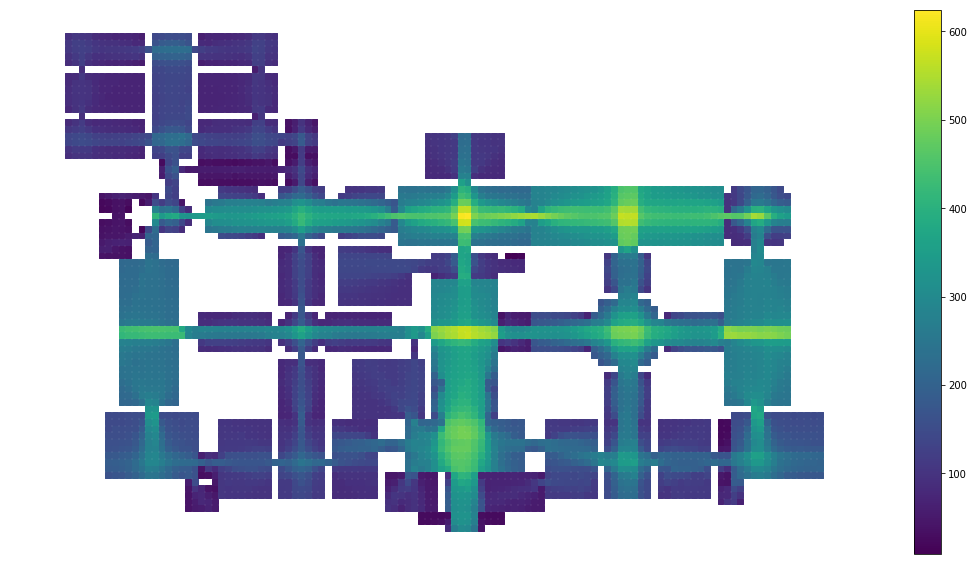

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
ax.set_aspect('equal')
galleryVGA.plot(ax=ax, column='Connectivity', cmap='viridis', marker='s', markersize=33, legend=True)
# https://matplotlib.org/examples/color/colormaps_reference.html

In [9]:
galleryAcc = geopandas.read_file("data/gallery-acc.shp")
galleryAcc.crs = ''
galleryPlan = geopandas.read_file("data/gallery-plan.shp")
galleryPlan.crs = ''

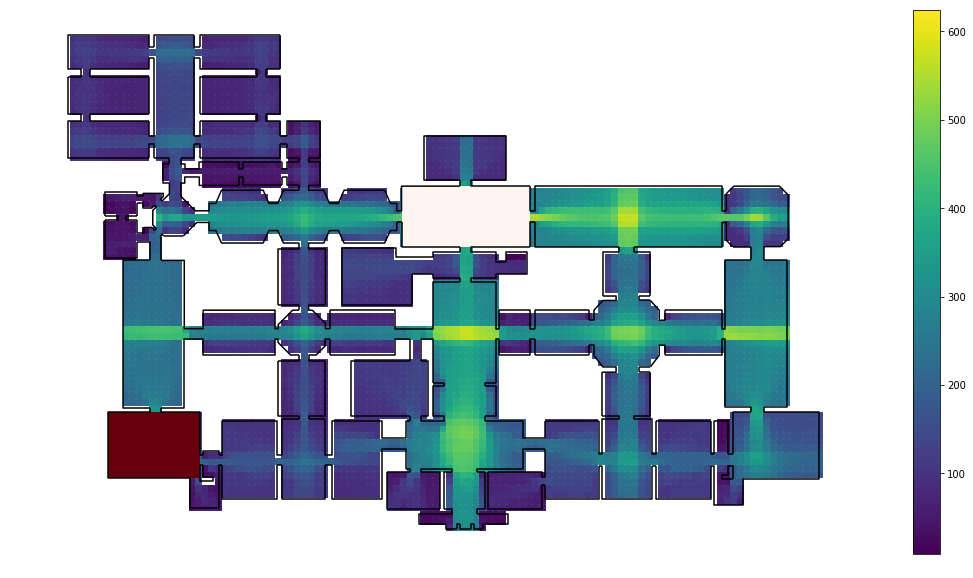

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
ax.set_aspect('equal')
galleryVGA.plot(ax=ax, column='Connectivity', cmap='viridis', marker='s', markersize=33, legend=True)
galleryAcc.plot(ax=ax, column='acc', cmap='Reds')
galleryPlan.plot(ax=ax, edgecolor='black')

In [11]:
# returns a new pandas DF one row for each point with the columns of the polygons
# DF that the point is first found in (if in multiple choses the first)
def pointsOverPolys(pointsDF, polysDF):
    condi = np.where(np.transpose(np.array(polysDF.apply(lambda row:
                pointsDF.intersects(polysDF.loc[[row.name]].unary_union),
                axis=1))))

    df = np.full((len(pointsDF.index), len(polysDF.columns)-1), None)
    df[condi[0]] = polysDF.iloc[condi[1],0:-1]
    df = pd.DataFrame(df, columns=polysDF.columns[0:-1]);
    df.fillna(value=pd.np.nan, inplace=True)
    df = df.infer_objects()
    return(df)

In [12]:
fin = pointsOverPolys(galleryVGA, galleryAcc)
galleryAcc.dtypes
#collections.Counter(fin)

id           int64
acc         object
geometry    object
dtype: object

In [13]:
overlapsDF = galleryVGA.join(fin)

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


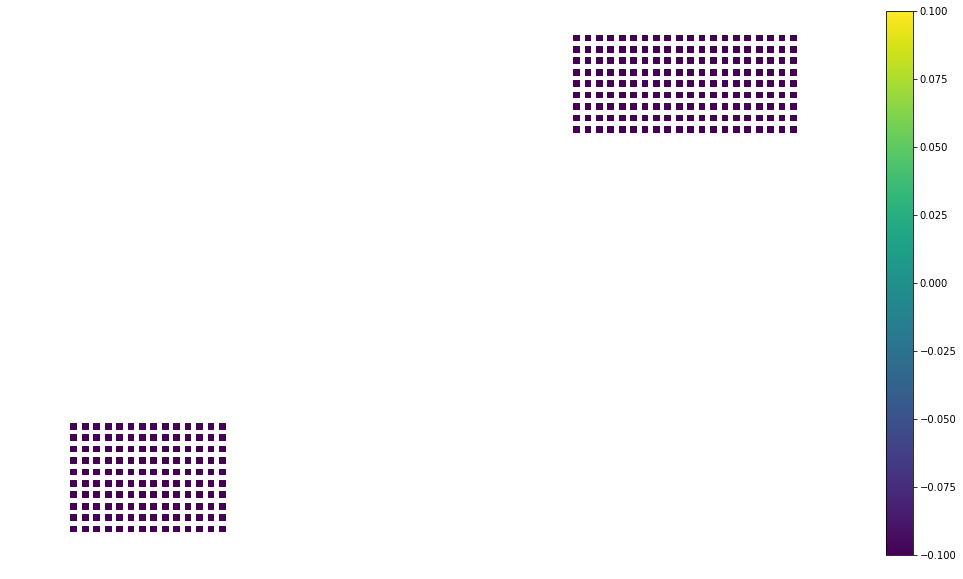

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
ax.set_aspect('equal')
overlapsDF.plot(ax=ax, column='id', cmap='viridis', marker='s', markersize=33, legend=True)
# https://matplotlib.org/examples/color/colormaps_reference.html

In [15]:
# Find the mean Connectivity per gallery
overlapsDF.groupby('acc')['Connectivity'].agg(['mean'])

,mean
acc,
Gallery1,336.188889
Gallery2,195.521429
